In [26]:
import sys
sys.path.append("../")

import QuantLib as ql
import pandas as pd
from datetime import datetime, timedelta 
from pandas.tseries.offsets import CustomBusinessDay 
from pandas.tseries.holiday import USFederalHolidayCalendar

from CurvyCUSIPs.CurveInterpolator import GeneralCurveInterpolator
from CurvyCUSIPs.CurveDataFetcher import CurveDataFetcher
from CurvyCUSIPs.USTs import USTs
from CurvyCUSIPs.S490Swaps import S490Swaps
from CurvyCUSIPs.S490Swaptions import S490Swaptions 
from CurvyCUSIPs.utils.regression_utils import run_multiple_linear_regression_df, run_basic_linear_regression_df, plot_residuals_timeseries

from CurvyCUSIPs.HedgeHog.beta import beta_estimates
from CurvyCUSIPs.HedgeHog.usts import dv01_neutral_curve_hedge_ratio, dv01_neutral_butterfly_hedge_ratio
import CurvyCUSIPs.HedgeHog.swaps as hh_swaps

from CurvyCUSIPs.Spectral.pca_residuals import PCAGridResiduals

import os
from dotenv import dotenv_values
env_path = os.path.join(os.getcwd(), "../.env")
config = dotenv_values(env_path)

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
plt.style.use('ggplot')
params = {'legend.fontsize': 'large',
        'figure.figsize': (15, 9),
        'axes.labelsize': 'large',
        'axes.titlesize':'large',
        'xtick.labelsize':'large',
        'ytick.labelsize':'large'}
pylab.rcParams.update(params)

import nest_asyncio
nest_asyncio.apply()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
curve_data_fetcher = CurveDataFetcher(use_ust_issue_date=True, fred_api_key=config["FRED_API_KEY"])

In [28]:
s490_swaps = S490Swaps(s490_curve_db_path=r"..\db\nyclose_sofr_ois", curve_data_fetcher=curve_data_fetcher)
s490_swaptions = S490Swaptions(s490_swaps)

..\db\nyclose_sofr_ois is behind --- cd into 'scripts' and run 'update_sofr_ois_db.py' to update --- most recent date in db: 2025-01-08 00:00:00
..\db\s490_swaption_atm_vol is behind --- cd into 'scripts' and run 'update_atm_swaption_vol.py' to update --- most recent date in db: 2025-01-07 00:00:00
..\db\s490_swaption_vol_cube is behind --- cd into 'scripts' and run 'update_atm_swaption_vol.py' to update --- most recent date in db: 2025-01-08 00:00:00


In [111]:
start_date = datetime(2023, 1, 1)
end_date = datetime(2025, 1, 8)
bdates = pd.date_range(start=start_date, end=end_date, freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))

In [112]:
fwd_tenors = ["1M", "3M", "6M", "9M", "12M", "18M", "2Y", "3Y", "4Y", "5Y", "6Y", "7Y", "8Y", "9Y", "10Y"]
fwd_grid_dict, ql_curves = s490_swaps.s490_nyclose_fwd_curve_matrices(
    start_date=start_date,
    end_date=end_date,
    ql_piecewise_method="logLinearDiscount",
    fwd_tenors=fwd_tenors,
)

Building Implied Fwd Curves...: 100%|██████████| 505/505 [00:04<00:00, 101.14it/s]


In [113]:
timeseries_df = s490_swaps.timeseries_builder(fwd_dict_df=fwd_grid_dict, cols=["10Y"], start_date=start_date, end_date=end_date)
timeseries_df

BUILDING OIS SWAP TIMESERIES DF...: 100%|██████████| 505/505 [00:00<00:00, 1033.21it/s]


,Date,10Y
0,2023-01-03,3.398500
1,2023-01-04,3.355500
2,2023-01-05,3.387200
3,2023-01-06,3.219100
4,2023-01-09,3.196000
...,...,...
498,2025-01-02,4.080846
499,2025-01-03,4.099969
500,2025-01-06,4.139669
501,2025-01-07,4.210303


In [114]:
swap_pca_grid_residuals = PCAGridResiduals(timeseries_grids=fwd_grid_dict)

In [115]:
swap_r2pca_results = swap_pca_grid_residuals.runner(
    remove_underlying_tenors=["1D", "1W", "2W", "3W", "1M", "2M", "3M", "4M", "5M", "6M", "9M"], 
    use_r2_algo=True, 
    # run_on_level_changes=True
)
swap_r2pca_results["residual_timeseries_dict"][end_date].style.background_gradient(cmap="RdYlGn", axis=0)

,Spot,1M Fwd,3M Fwd,6M Fwd,9M Fwd,12M Fwd,18M Fwd,2Y Fwd,3Y Fwd,4Y Fwd,5Y Fwd,6Y Fwd,7Y Fwd,8Y Fwd,9Y Fwd,10Y Fwd
Tenor,,,,,,,,,,,,,,,,
12M,7.802935,9.560102,-16.313976,-12.410523,-10.591201,-8.138431,7.530540,27.043835,13.170722,-10.333626,-22.957946,-17.721308,-12.735954,-9.949555,9.331109,20.913395
18M,0.685101,4.093640,-14.134664,-11.740917,-4.097047,3.312313,14.170834,22.442120,5.354331,-14.471531,-21.226191,-16.028962,-11.848553,-3.582373,13.181579,20.937709
2Y,1.789217,2.079876,-8.148206,-2.409060,3.371762,9.497268,13.868148,20.094025,1.384005,-16.649688,-20.328432,-15.214346,-11.376098,-0.304868,15.118119,20.949390
3Y,8.733511,10.056085,2.430293,5.141112,7.798823,10.701588,9.712147,9.912273,-6.737546,-16.994385,-17.774036,-13.487123,-4.467241,6.766852,17.077192,16.437267
4Y,8.621478,10.273438,3.573631,4.238283,4.732141,5.377414,3.062109,1.666942,-9.467599,-15.905750,-15.838374,-7.783350,1.866029,10.337212,14.656371,14.177136
5Y,4.016726,5.876462,0.090365,0.000701,-0.225799,-0.310567,-1.625382,-2.191844,-10.109622,-14.724810,-10.816834,-2.060818,5.687226,9.757301,13.204383,12.819570
6Y,-0.123412,1.081660,-3.585602,-3.437987,-3.392914,-3.213491,-3.858589,-3.908857,-10.097277,-10.726920,-5.540829,1.787069,5.965151,9.352361,12.234263,13.834174
7Y,-3.098635,-1.559719,-5.438320,-5.105008,-4.885028,-4.550644,-4.958842,-4.809133,-7.314140,-6.214501,-1.744029,2.578085,6.175321,9.073778,13.186411,14.625360
8Y,-4.873893,-2.914322,-6.266276,-5.891801,-5.610155,-5.259079,-4.380140,-3.035778,-3.792918,-2.805568,-0.607866,3.185440,6.323281,10.298134,13.961569,15.186458


In [116]:
swap_pca_results = swap_pca_grid_residuals.runner(
    remove_underlying_tenors=["1D", "1W", "2W", "3W", "1M", "2M", "3M", "4M", "5M", "6M", "9M"], 
    # run_on_level_changes=True
)
swap_pca_results["rich_cheap_residual_zscore_timeseries_dict"][end_date].style.background_gradient(cmap="RdYlGn", axis=0)

,Spot,1M Fwd,3M Fwd,6M Fwd,9M Fwd,12M Fwd,18M Fwd,2Y Fwd,3Y Fwd,4Y Fwd,5Y Fwd,6Y Fwd,7Y Fwd,8Y Fwd,9Y Fwd,10Y Fwd
Tenor,,,,,,,,,,,,,,,,
12M,-1.880308,-0.264468,2.729178,2.241492,1.533922,-0.318632,-2.053999,-1.571862,1.270731,0.700406,0.941756,-0.787892,-0.168190,0.575850,0.083532,-0.694091
18M,-2.320390,-0.015385,2.087468,1.513434,0.969826,-0.899793,-2.004733,-1.058291,1.275897,0.924323,0.385369,-0.856467,0.207735,0.589708,-0.121486,-0.695227
2Y,-2.701564,-1.554473,1.055579,1.144879,0.550807,-1.366230,-1.715140,-0.594783,1.163314,0.995185,-0.020244,-0.746321,0.425549,0.512950,-0.317612,-0.695786
3Y,-2.349544,-1.770056,0.021803,1.056721,0.846277,-1.027974,-1.239383,-0.131996,1.276747,0.285189,-0.121583,-0.082916,0.371634,0.199692,-0.550900,-0.278939
4Y,-2.049866,-1.052109,0.729544,1.971182,1.767978,-0.799312,-0.706725,0.369811,0.624579,0.157547,0.262939,-0.017526,0.092902,-0.078982,-0.177109,0.053625
5Y,-1.808691,-0.667929,1.266408,2.846424,2.883642,0.215196,-0.628307,-0.106691,0.477957,0.423848,0.250223,-0.233509,-0.148608,0.170570,0.090433,0.243708
6Y,-1.731827,-0.243574,1.411918,2.575048,2.015498,-0.656160,-0.848903,-0.174258,0.672903,0.391951,0.057233,-0.408312,0.086195,0.340109,0.253306,0.299681
7Y,-1.859164,-0.592527,0.692897,1.709013,1.323371,-0.638549,-0.567600,0.171266,0.610191,0.215399,-0.126626,-0.176099,0.264816,0.443862,0.306232,0.344332
8Y,-1.869298,-0.570758,0.627303,1.497059,1.301257,-0.000921,-0.241345,0.178908,0.447260,0.035777,0.060357,0.028903,0.375121,0.513351,0.359226,0.364371


In [117]:
tens_reg = swap_pca_results["reconstructed_df"].loc[:, ("10Y", "Spot")]
tens_r2 = swap_r2pca_results["reconstructed_df"].loc[:, ("10Y", "Spot")]

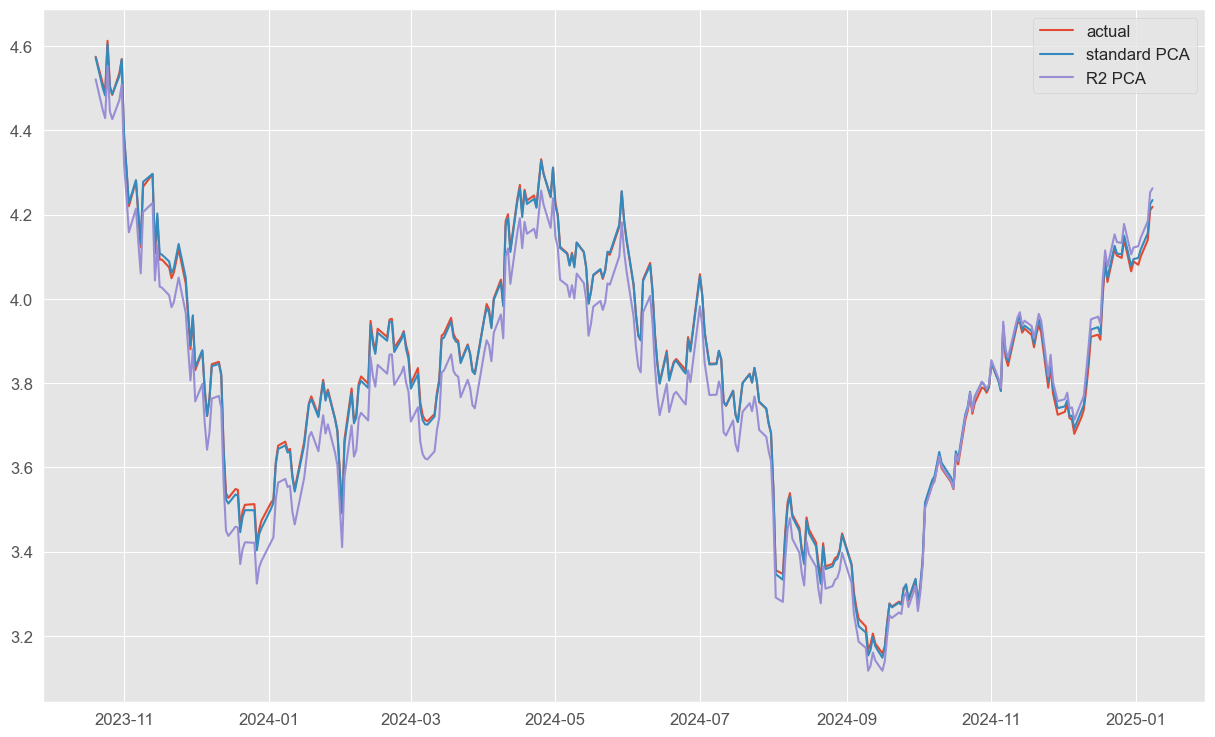

In [121]:
# dts = []
# r2 = []
# pca = []

# for dt, df in swap_pca_results["residual_timeseries_dict"].items():
#     dts.append(dt)
#     pca.append(df.loc["10Y"]["12M Fwd"])


# for dt, df in swap_r2pca_results["residual_timeseries_dict"].items():
#     r2.append(df.loc["10Y"]["12M Fwd"])

plt.plot(timeseries_df["Date"][200:], timeseries_df["10Y"][200:], label="actual")
plt.plot(tens_reg.index[200:], tens_reg.values[200:], label="standard PCA")
plt.plot(tens_r2.index[200:], tens_r2.values[200:], label="R2 PCA")
plt.legend()

In [22]:
atm_vol_surfaces_dict = s490_swaptions.get_vol_surfaces(start_date=start_date, end_date=end_date)

In [24]:
swaption_pca_residuals = PCAGridResiduals(timeseries_grids=atm_vol_surfaces_dict)
swaption_pca_results = swaption_pca_residuals.runner(n_jobs=-1, run_on_level_changes=True)

In [25]:
swaption_pca_results["rich_cheap_residual_zscore_timeseries_dict"][end_date].style.background_gradient(cmap="RdYlGn_r", axis=0)

,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y,15Y,20Y,25Y,30Y
Expiry,,,,,,,,,,,,,,
1M,-0.976289,0.330465,0.449639,0.374406,0.205061,0.454053,0.675044,0.846236,0.972872,1.062446,0.936090,0.737010,0.528869,0.352384
3M,-1.042606,-0.585515,-0.670824,-0.555992,-0.390756,-0.262348,-0.117197,0.048904,0.225915,0.401965,0.357958,0.248587,0.121790,0.020168
6M,-0.382798,0.034643,0.294070,0.285228,0.211166,0.409131,0.566037,0.682541,0.800035,0.876746,0.931277,0.910096,0.786564,0.613567
9M,-0.074070,0.159745,0.328864,0.153864,-0.061774,0.150660,0.435295,0.599896,0.733049,0.766137,0.656657,0.445694,0.182572,-0.020046
1Y,0.286482,0.202724,0.253835,0.005804,-0.325004,-0.176004,0.017595,0.044099,0.068565,0.086205,-0.095074,-0.248503,-0.374449,-0.476457
2Y,0.612573,0.586709,0.586251,0.483762,0.273041,0.045179,-0.197196,-0.423330,-0.641278,-0.833760,-1.005822,-1.126353,-1.210773,-1.254949
3Y,0.691477,0.349271,0.325854,0.231479,0.085174,-0.128284,-0.388251,-0.685697,-0.992797,-1.273257,-1.516697,-1.665314,-1.729941,-1.740106
4Y,0.679424,0.155023,0.110260,0.155318,-0.060819,-0.400151,-0.581143,-0.804886,-1.124319,-1.496533,-1.825926,-1.963179,-1.964688,-1.935674
5Y,0.601984,-0.171277,-0.246945,-0.271065,-0.308414,-0.521960,-0.762248,-1.021882,-1.260139,-1.432901,-1.743126,-1.908252,-1.930875,-1.894877
